#Import Library + Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import kagglehub as kh
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE

In [2]:
path = kh.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


#EDA

##5 Baris Pertama

In [3]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##Deskripsi

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


##Missing Value

In [6]:
mv_percentages = df.isnull().sum() / len(df) * 100
mv_percentages = mv_percentages[mv_percentages > 0].sort_values(ascending=False)
print("Missing Value:")
for column_name, percentage in mv_percentages.items():
    print(f"{column_name}: {percentage:.2f}%")

Missing Value:


##Label Distribution

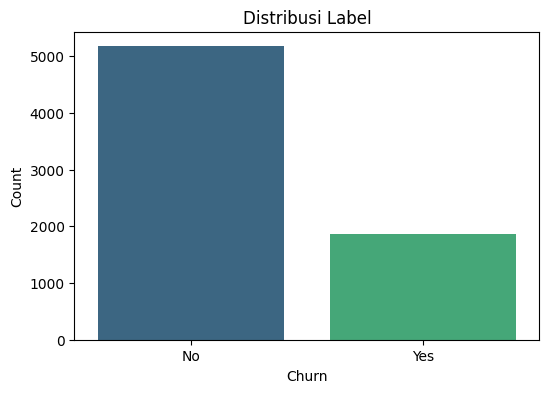

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribusi Label')
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

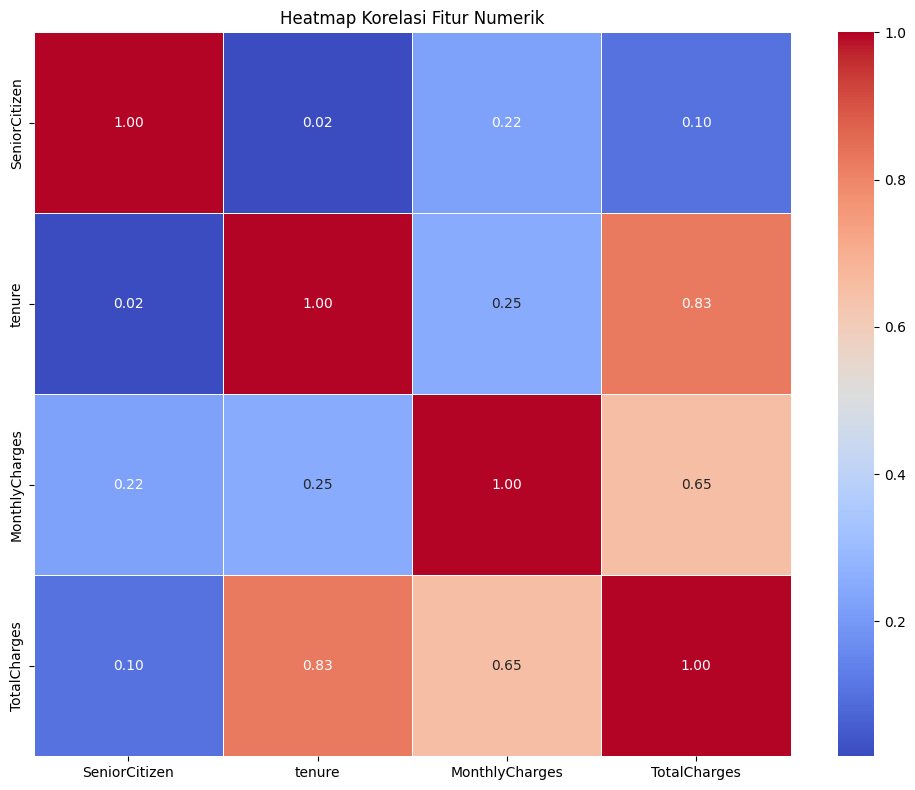

In [9]:
df_numerik = df.select_dtypes(include=['float64', 'int64'])
cr_value = df_numerik.corr()
plt.figure(figsize=(10,8))
sns.heatmap(cr_value, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Heatmap Korelasi Fitur Numerik')
plt.tight_layout()
plt.show()

#Direct Modeling

##Copy Dataframe utama menjadi Dataframe Baru untuk Direct Modelling

In [10]:
df_train1_raw = df.copy()

##Ganti Kolom Objek menjadi numerik dengan encoding sederhana

In [11]:
obj_cols = []
for col in df_train1_raw.columns:
    if df_train1_raw[col].dtype == 'object' and col != 'Churn':
        obj_cols.append(col)

ohe_encoder = OneHotEncoder(sparse_output=False)
one_encoded = ohe_encoder.fit_transform(df_train1_raw[obj_cols])


encoded_df = pd.DataFrame(one_encoded,
                          columns=ohe_encoder
                          .get_feature_names_out(obj_cols))

df_train1_raw = pd.concat([df_train1_raw.drop(obj_cols, axis=1), encoded_df], axis=1)

le = LabelEncoder()
df_train1_raw['Churn'] = le.fit_transform(df_train1_raw['Churn'])


In [12]:
df_train1_raw.isna().sum()

,0
SeniorCitizen,0
tenure,0
MonthlyCharges,0
TotalCharges,11
Churn,0
...,...
PaperlessBilling_Yes,0
PaymentMethod_Bank transfer (automatic),0
PaymentMethod_Credit card (automatic),0
PaymentMethod_Electronic check,0


In [13]:
numeric_cols = ['TotalCharges']
for col in numeric_cols:
    median_value = df_train1_raw[col].median()
    df_train1_raw[col].fillna(median_value, inplace=True)

##Menentukan X dan y untuk model training

In [14]:
X = df_train1_raw.drop('Churn', axis=1)
y = df_train1_raw['Churn']

##Data Splitting

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##Model 1: Decision Tree (Direct Modeling)

In [16]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, Y_train)
dt_prediction = dt_classifier.predict(X_test)

print('Accuracy :', accuracy_score(Y_test, dt_prediction))
print('Precision :', precision_score(Y_test, dt_prediction, average='weighted'))
print('Recall :', recall_score(Y_test, dt_prediction, average='weighted'))
print('F1 Score :', f1_score(Y_test, dt_prediction, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test, dt_prediction))

Accuracy : 0.7699952673923331
Precision : 0.7595471171868398
Recall : 0.7699952673923331
F1 Score : 0.7629790873181066

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      1539
           1       0.59      0.49      0.54       574

    accuracy                           0.77      2113
   macro avg       0.71      0.68      0.69      2113
weighted avg       0.76      0.77      0.76      2113



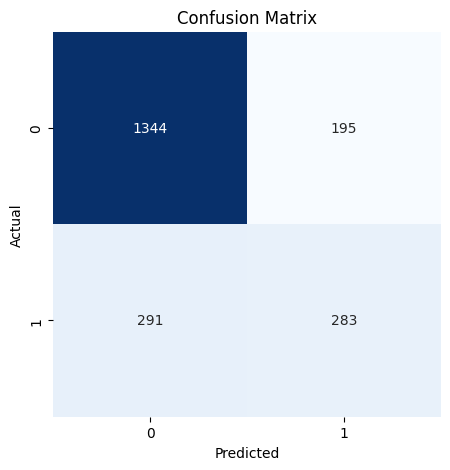

In [17]:
cm1 = confusion_matrix(Y_test, dt_prediction)
plt.figure(figsize=(5,5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Model 2: Random Forest (Direct Modeling)

In [18]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, Y_train)
rf_prediction = rf_classifier.predict(X_test)

print('Accuracy :', accuracy_score(Y_test, rf_prediction))
print('Precision :', precision_score(Y_test, rf_prediction, average='weighted'))
print('Recall :', recall_score(Y_test, rf_prediction, average='weighted'))
print('F1 Score :', f1_score(Y_test, rf_prediction, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test, rf_prediction))

Accuracy : 0.7917652626597255
Precision : 0.7789854050496574
Recall : 0.7917652626597255
F1 Score : 0.7779616342766863

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1539
           1       0.67      0.46      0.54       574

    accuracy                           0.79      2113
   macro avg       0.75      0.69      0.70      2113
weighted avg       0.78      0.79      0.78      2113



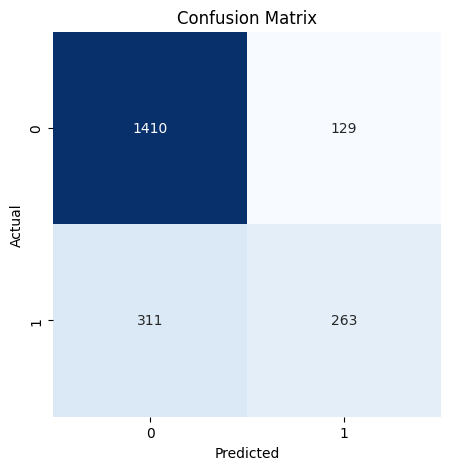

In [19]:
cm2 = confusion_matrix(Y_test, rf_prediction)
plt.figure(figsize=(5,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Model 3: Ensemble Voting (RandomForest, KNN, Decision Tree)

In [20]:
clf1 = RandomForestClassifier(random_state=42)
clf2 = KNeighborsClassifier()
clf3 = DecisionTreeClassifier(random_state=42)

vt_classifier = VotingClassifier(
    estimators=[('rf', clf1), ('knn', clf2), ('dt', clf3)],
    voting='hard'
)
vt_classifier.fit(X_train, Y_train)
vt_prediction = vt_classifier.predict(X_test)

print('Accuracy :', accuracy_score(Y_test, vt_prediction))
print('Precision :', precision_score(Y_test, vt_prediction, average='weighted'))
print('Recall :', recall_score(Y_test, vt_prediction, average='weighted'))
print('F1 Score :', f1_score(Y_test, vt_prediction, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test, vt_prediction))

Accuracy : 0.7927117841930904
Precision : 0.7800246710235217
Recall : 0.7927117841930904
F1 Score : 0.7783808547906712

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1539
           1       0.68      0.45      0.54       574

    accuracy                           0.79      2113
   macro avg       0.75      0.69      0.70      2113
weighted avg       0.78      0.79      0.78      2113



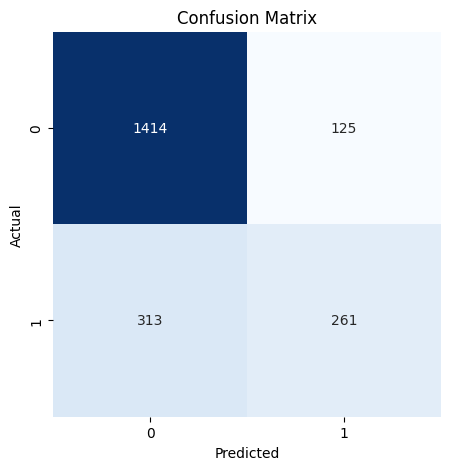

In [21]:
cm3 = confusion_matrix(Y_test, vt_prediction)
plt.figure(figsize=(5,5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Evaluasi

#Preprocessing

In [22]:
df_train2_raw = df.copy()
df_train2_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [23]:
df_train2_raw.drop('customerID', axis=1, inplace=True)
df_train2_raw.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##Ganti TotalCharges ke Numerik

In [24]:
numeric_cols = ['TotalCharges']
for col in numeric_cols:
    median_value = df_train2_raw[col].median()
    df_train2_raw[col].fillna(median_value, inplace=True)

##Penanganan Missing Value

In [25]:
mv_percentages = df_train2_raw.isnull().sum() / len(df) * 100
mv_percentages = mv_percentages[mv_percentages > 0].sort_values(ascending=False)
print("Missing Value:")
for column_name, percentage in mv_percentages.items():
    print(f"{column_name}: {percentage:.2f}%")

Missing Value:


##Pengecekan Invalid record/data

In [26]:
for column in df_train2_raw.columns:
  if df_train2_raw[column].dtype == 'object':
    print(f"\nColumn': {column}")
    print(df[column].nunique())
    print(df[column].unique())


Column': gender
2
['Female' 'Male']

Column': Partner
2
['Yes' 'No']

Column': Dependents
2
['No' 'Yes']

Column': PhoneService
2
['No' 'Yes']

Column': MultipleLines
3
['No phone service' 'No' 'Yes']

Column': InternetService
3
['DSL' 'Fiber optic' 'No']

Column': OnlineSecurity
3
['No' 'Yes' 'No internet service']

Column': OnlineBackup
3
['Yes' 'No' 'No internet service']

Column': DeviceProtection
3
['No' 'Yes' 'No internet service']

Column': TechSupport
3
['No' 'Yes' 'No internet service']

Column': StreamingTV
3
['No' 'Yes' 'No internet service']

Column': StreamingMovies
3
['No' 'Yes' 'No internet service']

Column': Contract
3
['Month-to-month' 'One year' 'Two year']

Column': PaperlessBilling
2
['Yes' 'No']

Column': PaymentMethod
4
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Column': Churn
2
['No' 'Yes']


In [27]:
for column in df_train2_raw.columns:
  if df_train2_raw[column].dtype == 'int64':
    print(f"\nColumn': {column}")
    print(df[column].nunique())
    print(df[column].unique())


Column': SeniorCitizen
2
[0 1]

Column': tenure
73
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]


In [28]:
for column in df_train2_raw.columns:
  if df_train2_raw[column].dtype == 'float64':
    print(f"\nColumn': {column}")
    print(df[column].nunique())
    print(df[column].unique())


Column': MonthlyCharges
1585
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]

Column': TotalCharges
6530
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]


##Pengecekan Data Duplikat

In [29]:
df_train2_raw.duplicated().sum()

np.int64(22)

In [30]:
df_train2_raw.drop_duplicates(inplace=True)

In [31]:
df_train2_raw.reset_index(drop=True, inplace=True)

In [32]:
df_train2_raw.duplicated().sum()

np.int64(0)

##Penanganan Outlier

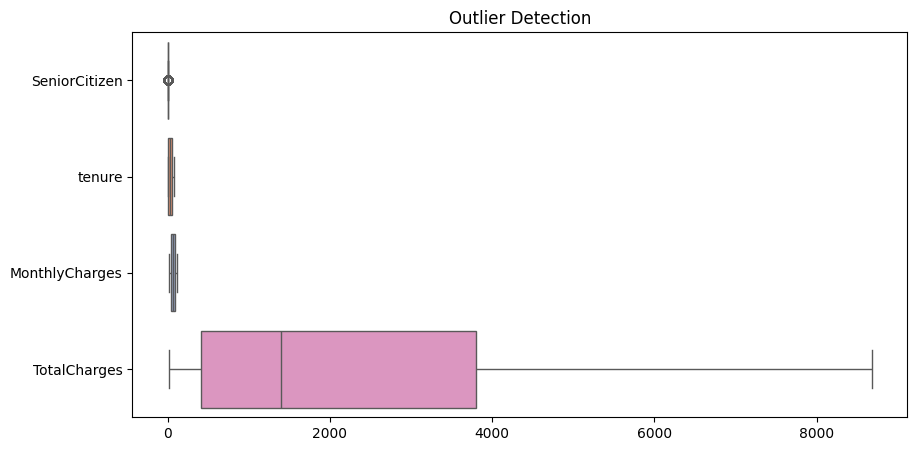

In [33]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_train2_raw, orient='h', palette='Set2')
plt.title('Outlier Detection')
plt.show()

In [34]:
outlier_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
for col in outlier_cols:
    Q1 = df_train2_raw[col].quantile(0.25)
    Q3 = df_train2_raw[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_train2_raw[(df_train2_raw[col] < lower_bound) | (df_train2_raw[col] > upper_bound)]
    percentage_outliers = (len(outliers) / len(df_train2_raw)) * 100
    print(f"Outliers pada kolom '{col}': {percentage_outliers:.2f}%")

Outliers pada kolom 'SeniorCitizen': 16.25%
Outliers pada kolom 'tenure': 0.00%
Outliers pada kolom 'MonthlyCharges': 0.00%
Outliers pada kolom 'TotalCharges': 0.00%


In [35]:
df_store = df_train2_raw.copy()

##Encoding Data

In [36]:
#-----------------------------One Hot Encoding--------------------------------
obj_cols = []

for col in df_train2_raw.columns:
    if df_train2_raw[col].dtype == 'object' and col != 'Churn' and col !='Contract' and col !='customerID':
        obj_cols.append(col)

ohe_encoder2 = OneHotEncoder(sparse_output=False)
one_encoded2 = ohe_encoder2.fit_transform(df_train2_raw[obj_cols])

encoded_df2 = pd.DataFrame(one_encoded2,
                          columns=ohe_encoder2
                          .get_feature_names_out(obj_cols))

df_train2_raw = pd.concat([df_train2_raw.drop(obj_cols, axis=1), encoded_df2], axis=1)

#--------------------------------Ordinal--------------------------------
mapping_contract = {
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
}

df_train2_raw['Contract'] = df_train2_raw['Contract'].map(mapping_contract)

#--------------------------------Label-----------------------------------
le = LabelEncoder()
df_train2_raw['Churn'] = le.fit_transform(df_train2_raw['Churn'])

##Feature Scaling

In [37]:
scaler = MinMaxScaler()
non_normalized_cols = ['TotalCharges', 'MonthlyCharges', 'tenure']
for col in non_normalized_cols:
    df_train2_raw[col] = scaler.fit_transform(df_train2_raw[[col]])

##Modeling Dengan Preprocessing

In [38]:
X2 = df_train2_raw.drop('Churn', axis=1)
y2 = df_train2_raw['Churn']

In [39]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

###Model Processing 1: Decision Tree

Accuracy : 0.7346938775510204
Precision : 0.7342282076069075
Recall : 0.7346938775510204
F1 Score : 0.7344595230410002

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1556
           1       0.49      0.49      0.49       551

    accuracy                           0.73      2107
   macro avg       0.66      0.66      0.66      2107
weighted avg       0.73      0.73      0.73      2107



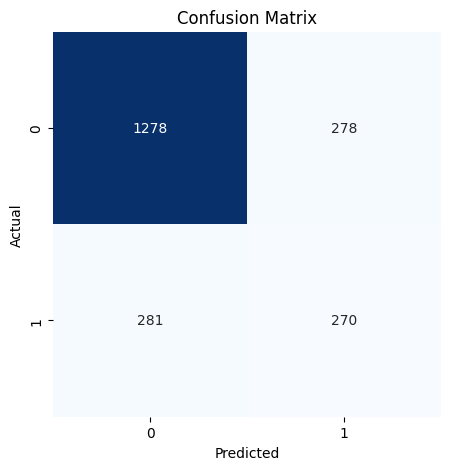

In [40]:
dt_classifier2 = DecisionTreeClassifier(random_state=42)
dt_classifier2.fit(X_train2, Y_train2)
dt_prediction2 = dt_classifier2.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, dt_prediction2))
print('Precision :', precision_score(Y_test2, dt_prediction2, average='weighted'))
print('Recall :', recall_score(Y_test2, dt_prediction2, average='weighted'))
print('F1 Score :', f1_score(Y_test2, dt_prediction2, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, dt_prediction2))

cm4 = confusion_matrix(Y_test2, dt_prediction2)
plt.figure(figsize=(5,5))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###Model Processing 2 : Random Forest

Accuracy : 0.7883246321784527
Precision : 0.7757084988700182
Recall : 0.7883246321784527
F1 Score : 0.7784133404003789

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1556
           1       0.62      0.48      0.54       551

    accuracy                           0.79      2107
   macro avg       0.73      0.69      0.70      2107
weighted avg       0.78      0.79      0.78      2107



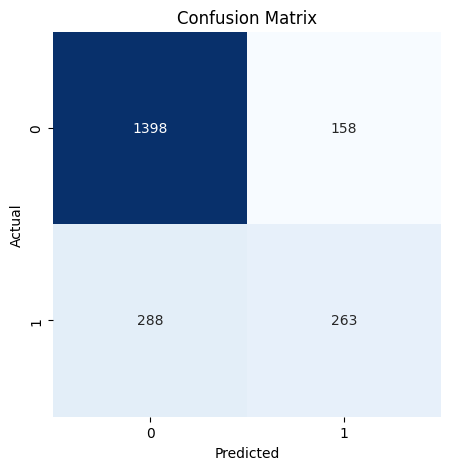

In [41]:
rf_classifier2 = RandomForestClassifier(random_state=42)
rf_classifier2.fit(X_train2, Y_train2)
rf_prediction2 = rf_classifier2.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, rf_prediction2))
print('Precision :', precision_score(Y_test2, rf_prediction2, average='weighted'))
print('Recall :', recall_score(Y_test2, rf_prediction2, average='weighted'))
print('F1 Score :', f1_score(Y_test2, rf_prediction2, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, rf_prediction2))

cm5 = confusion_matrix(Y_test2, rf_prediction2)
plt.figure(figsize=(5,5))
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###Model Processing 3: Ensemble Voting

Accuracy : 0.783578547698149
Precision : 0.7723001365582989
Recall : 0.783578547698149
F1 Score : 0.7756265754986675

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1556
           1       0.61      0.49      0.54       551

    accuracy                           0.78      2107
   macro avg       0.72      0.69      0.70      2107
weighted avg       0.77      0.78      0.78      2107



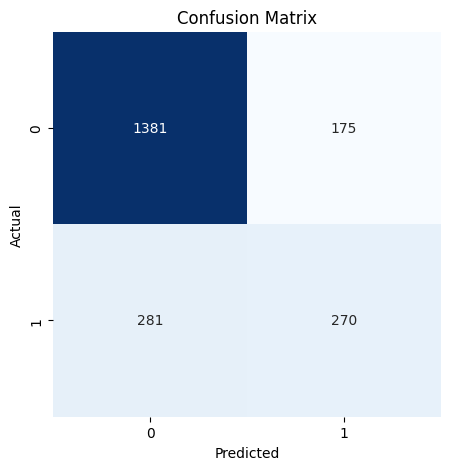

In [42]:
clf2_1 = RandomForestClassifier(random_state=42)
clf2_2 = KNeighborsClassifier()
clf2_3 = DecisionTreeClassifier(random_state=42)

vt_classifier2 = VotingClassifier(
    estimators=[('rf', clf2_1), ('knn', clf2_2), ('dt', clf2_3)],
    voting='hard'
)
vt_classifier2.fit(X_train2, Y_train2)
vt_prediction2 = vt_classifier2.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, vt_prediction2))
print('Precision :', precision_score(Y_test2, vt_prediction2, average='weighted'))
print('Recall :', recall_score(Y_test2, vt_prediction2, average='weighted'))
print('F1 Score :', f1_score(Y_test2, vt_prediction2, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, vt_prediction2))

cm6 = confusion_matrix(Y_test2, vt_prediction2)
plt.figure(figsize=(5,5))
sns.heatmap(cm6, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
df_train2_raw.head()

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0.013889,0,0.115423,0.001275,0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0,0.472222,1,0.385075,0.215867,0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0.027778,0,0.354229,0.010310,1,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0,0.625000,1,0.239303,0.210241,0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0.027778,0,0.521891,0.015330,1,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


##Evaluasi Model

#Hyperparameter Tuning

In [44]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [45]:
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=dt_param_dist, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train2, Y_train2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [46]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

In [51]:
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=rf_param_dist, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train2, Y_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [52]:
vt_model = VotingClassifier(
    estimators=[('rf', RandomForestClassifier(random_state=42)), ('knn', KNeighborsClassifier()), ('dt', DecisionTreeClassifier(random_state=42))],
    voting='hard'
)

vt_param_dist = {
    'rf__max_depth': [10],
    'rf__min_samples_leaf': [4],
    'rf__max_features': ['log2'],
    'rf__n_estimators': [200],

    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],

    'dt__max_depth': [10],
    'dt__min_samples_leaf': [4],

    'voting' : ['hard', 'soft'],
}

In [53]:
gridsearch_vt = GridSearchCV(estimator=vt_model, param_grid=vt_param_dist, cv=5, scoring='accuracy', n_jobs=-1)
gridsearch_vt.fit(X_train2, Y_train2)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('knn',
                                                     KNeighborsClassifier()),
                                                    ('dt',
                                                     DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [10], 'dt__min_samples_leaf': [4],
                         'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance'],
                         'rf__max_depth': [10], 'rf__max_features': ['log2'],
                         'rf__min_samples_leaf': [4], 'rf__n_estimators': [200],
                         'voting': ['hard', 'soft']},
             scoring='accuracy')

Accuracy : 0.7631703844328429
Precision : 0.7584894305901799
Recall : 0.7631703844328429
F1 Score : 0.7606030867352261

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1556
           1       0.55      0.52      0.53       551

    accuracy                           0.76      2107
   macro avg       0.69      0.68      0.69      2107
weighted avg       0.76      0.76      0.76      2107



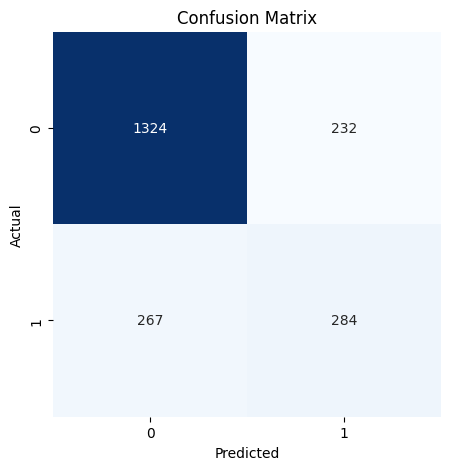

In [54]:
dt_classifier3 = grid_search_dt.best_estimator_
dt_classifier3.fit(X_train2, Y_train2)
dt_prediction3 = dt_classifier3.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, dt_prediction3))
print('Precision :', precision_score(Y_test2, dt_prediction3, average='weighted'))
print('Recall :', recall_score(Y_test2, dt_prediction3, average='weighted'))
print('F1 Score :', f1_score(Y_test2, dt_prediction3, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, dt_prediction3))

cm7 = confusion_matrix(Y_test2, dt_prediction3)
plt.figure(figsize=(5,5))
sns.heatmap(cm7, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy : 0.7963929757949691
Precision : 0.7841281786195993
Recall : 0.7963929757949691
F1 Score : 0.7858687771721997

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1556
           1       0.65      0.48      0.55       551

    accuracy                           0.80      2107
   macro avg       0.74      0.70      0.71      2107
weighted avg       0.78      0.80      0.79      2107



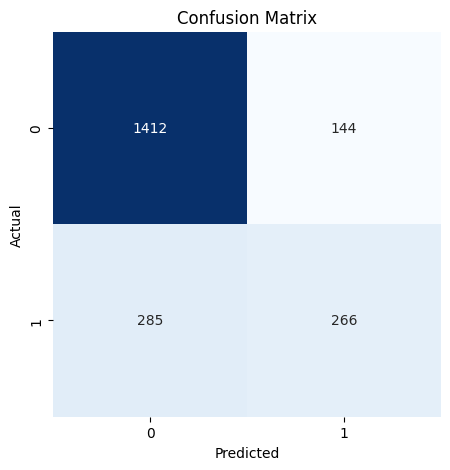

In [55]:
rf_classifier3 = grid_search_rf.best_estimator_
rf_classifier3.fit(X_train2, Y_train2)
rf_prediction3 = rf_classifier3.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, rf_prediction3))
print('Precision :', precision_score(Y_test2, rf_prediction3, average='weighted'))
print('Recall :', recall_score(Y_test2, rf_prediction3, average='weighted'))
print('F1 Score :', f1_score(Y_test2, rf_prediction3, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, rf_prediction3))

cm8 = confusion_matrix(Y_test2, rf_prediction3)
plt.figure(figsize=(5,5))
sns.heatmap(cm8, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy : 0.7940199335548173
Precision : 0.7832253271993231
Recall : 0.7940199335548173
F1 Score : 0.7859463533882138

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1556
           1       0.63      0.50      0.56       551

    accuracy                           0.79      2107
   macro avg       0.73      0.70      0.71      2107
weighted avg       0.78      0.79      0.79      2107



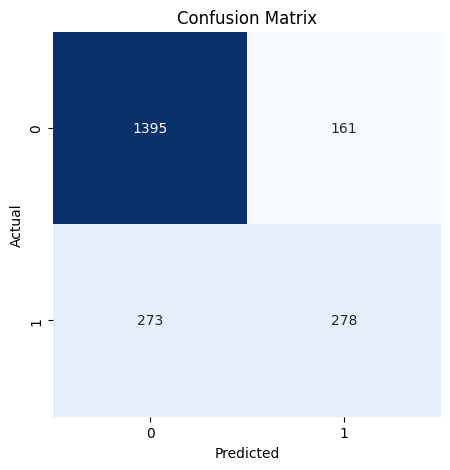

In [56]:
vt_classifier3 = gridsearch_vt.best_estimator_
vt_classifier3.fit(X_train2, Y_train2)
vt_prediction3 = vt_classifier3.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, vt_prediction3))
print('Precision :', precision_score(Y_test2, vt_prediction3, average='weighted'))
print('Recall :', recall_score(Y_test2, vt_prediction3, average='weighted'))
print('F1 Score :', f1_score(Y_test2, vt_prediction3, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, vt_prediction3))

cm9 = confusion_matrix(Y_test2, vt_prediction3)
plt.figure(figsize=(5,5))
sns.heatmap(cm9, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Evaluasi

#Best Model

In [63]:
import joblib

In [ ]:
joblib.dump(gridsearch_vt.best_estimator_, 'best_model_vt.pkl')

In [ ]:
joblib.dump(grid_search_rf.best_estimator_, 'best_model_rf.pkl')

In [64]:
X3 = df_store.drop('Churn', axis=1)
y3 = df_store['Churn']

In [65]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [77]:
# 1. Definisi Kolom
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
ord_cols = ['Contract']
nom_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'PaperlessBilling', 'PaymentMethod']
label_cols = ['Churn']

# 2. Inisialisasi & Fit Preprocessor
# A. MinMax Scaler
scaler = MinMaxScaler()
scaler.fit(X_train3[num_cols]) # Belajar range data training

# B. Ordinal Encoder (Contract)
contract_order = [['Month-to-month', 'One year', 'Two year']]
ord_enc = OrdinalEncoder(categories=contract_order)
ord_enc.fit(X_train3[ord_cols])

# C. OneHot Encoder (Sisa kategori)
oh_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
oh_enc.fit(X_train3[nom_cols])

le_enc = LabelEncoder()
le_enc.fit(Y_train3['label_cols'])

# 3. Transformasi Data Training (Agar bisa masuk ke Model)
# Kita harus mengubah X_train secara manual untuk fitting model
X_train_num = pd.DataFrame(scaler.transform(X_train3[num_cols]), columns=num_cols, index=X_train3.index)
X_train_ord = pd.DataFrame(ord_enc.transform(X_train3[ord_cols]), columns=ord_cols, index=X_train3.index)
X_train_nom = pd.DataFrame(oh_enc.transform(X_train3[nom_cols]), columns=oh_enc.get_feature_names_out(nom_cols), index=X_train3.index)
X_train_le = pd.DataFrame(le_enc.transform(X_train3[label_cols]), columns=label_cols, index=X_train3.index)
# Gabungkan kembali
X_train_final = pd.concat([X_train_num, X_train_ord, X_train_nom, X_train_le], axis=1)

# 4. Train Model
model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features='log2', random_state=42)
model.fit(X_train_final, Y_train2)

# 5. SIMPAN SEMUA KOMPONEN (Akan ada 4 file)
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(ord_enc, 'ordinal_encoder.pkl')
joblib.dump(oh_enc, 'onehot_encoder.pkl')
joblib.dump(model, 'model_only.pkl')
joblib.dump(le_enc, 'label_encoder.pkl')

KeyError: 'label_cols'

In [71]:
df_store.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#Test

In [57]:
df_test = df_train2_raw.copy()

In [58]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train2, Y_train2)
df_test = pd.concat([X_resampled, pd.Series(y_resampled, name='Churn')], axis=1)

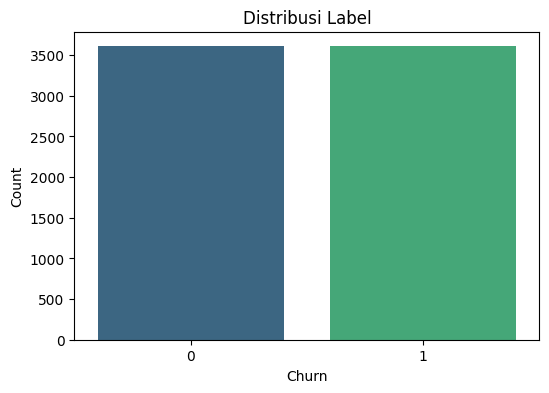

In [59]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df_test, palette='viridis')
plt.title('Distribusi Label')
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

Accuracy : 0.7655434266729948
Precision : 0.794410133737627
Recall : 0.7655434266729948
F1 Score : 0.7746602325309598

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1556
           1       0.54      0.71      0.61       551

    accuracy                           0.77      2107
   macro avg       0.71      0.75      0.72      2107
weighted avg       0.79      0.77      0.77      2107



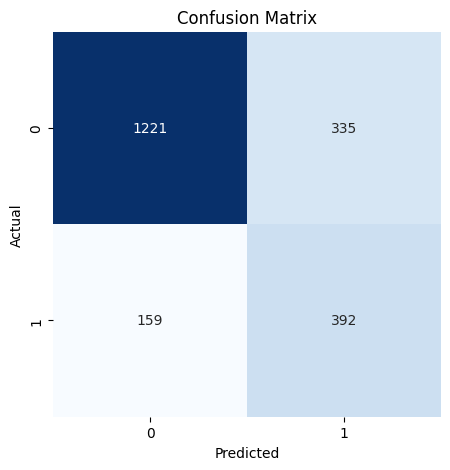

In [60]:
vt_classifier4 = gridsearch_vt.best_estimator_
vt_classifier4.fit(X_resampled, y_resampled)
vt_prediction4 = vt_classifier4.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, vt_prediction4))
print('Precision :', precision_score(Y_test2, vt_prediction4, average='weighted'))
print('Recall :', recall_score(Y_test2, vt_prediction4, average='weighted'))
print('F1 Score :', f1_score(Y_test2, vt_prediction4, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, vt_prediction4))

cm10 = confusion_matrix(Y_test2, vt_prediction4)
plt.figure(figsize=(5,5))
sns.heatmap(cm10, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy : 0.7807308970099668
Precision : 0.7986483318318583
Recall : 0.7807308970099668
F1 Score : 0.7870998663995724

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.85      1556
           1       0.57      0.69      0.62       551

    accuracy                           0.78      2107
   macro avg       0.72      0.75      0.73      2107
weighted avg       0.80      0.78      0.79      2107



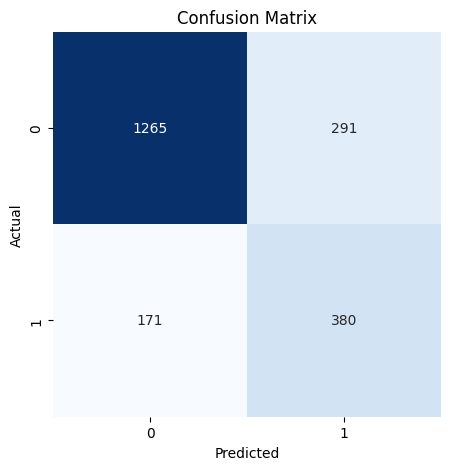

In [61]:
rf_classifier4 = grid_search_rf.best_estimator_
rf_classifier4.fit(X_resampled, y_resampled)
rf_prediction4 = rf_classifier4.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, rf_prediction4))
print('Precision :', precision_score(Y_test2, rf_prediction4, average='weighted'))
print('Recall :', recall_score(Y_test2, rf_prediction4, average='weighted'))
print('F1 Score :', f1_score(Y_test2, rf_prediction4, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, rf_prediction4))

cm11 = confusion_matrix(Y_test2, rf_prediction4)
plt.figure(figsize=(5,5))
sns.heatmap(cm11, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy : 0.7527289985761747
Precision : 0.7787134028578179
Recall : 0.7527289985761747
F1 Score : 0.7615778209422623

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1556
           1       0.52      0.67      0.59       551

    accuracy                           0.75      2107
   macro avg       0.70      0.73      0.70      2107
weighted avg       0.78      0.75      0.76      2107



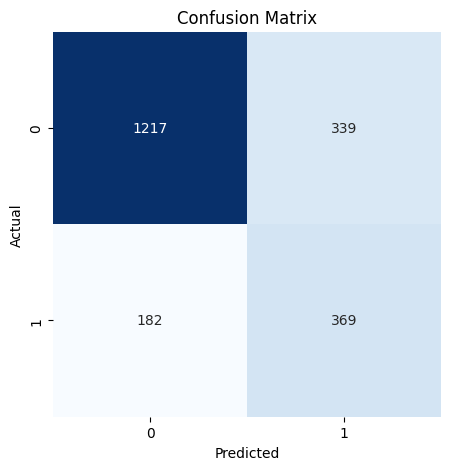

In [62]:
dt_classifier4 = grid_search_dt.best_estimator_
dt_classifier4.fit(X_resampled, y_resampled)
dt_prediction4 = dt_classifier4.predict(X_test2)

print('Accuracy :', accuracy_score(Y_test2, dt_prediction4))
print('Precision :', precision_score(Y_test2, dt_prediction4, average='weighted'))
print('Recall :', recall_score(Y_test2, dt_prediction4, average='weighted'))
print('F1 Score :', f1_score(Y_test2, dt_prediction4, average='weighted'))
print('\nClassification Report:\n', classification_report(Y_test2, dt_prediction4))

cm12 = confusion_matrix(Y_test2, dt_prediction4)
plt.figure(figsize=(5,5))
sns.heatmap(cm12, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()